#  <center> Speech Emotion Recognition <center>

Datasets contains 8 types of emotions:

Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

# Importing Libraries

In [43]:
import pandas as pd
import numpy as np

import os
import sys
import random

# librosa is a Python library for analyzing audio and music.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

from tensorflow.keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
#from keras.layers.recurrent import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.optimizers import adam_v2
from keras.layers import Dropout

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation
Creating a dataframe storing all emotions of the data in dataframe with their paths. I will use this dataframe to extract features for our model training.

In [44]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [45]:
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_statement = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that auido.
        file_emotion.append(int(part[2]))
        file_statement.append(int(part[4]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
#emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
#path_df = pd.DataFrame(file_path, columns=['Path'])
#Ravdess_df = pd.concat([emotion_df, path_df], axis=1)
Ravdess_df = pd.DataFrame({"Emotions":file_emotion, "Statement":file_statement, "Path":file_path})

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
# Removing fear and disgust as they are not relevant
Ravdess_df = Ravdess_df[~Ravdess_df['Emotions'].isin(['fear', 'disgust'])]

# Display first five rows
Ravdess_df.head()

,Emotions,Statement,Path
0,surprise,1,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,1,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,2,/kaggle/input/ravdess-emotional-speech-audio/a...
6,sad,2,/kaggle/input/ravdess-emotional-speech-audio/a...
7,neutral,1,/kaggle/input/ravdess-emotional-speech-audio/a...


In [46]:
Ravdess_df['Emotions'].value_counts()


surprise    192
sad         192
calm        192
happy       192
angry       192
neutral      96
Name: Emotions, dtype: int64

In [47]:
Ravdess_df.shape

(1056, 3)

In [48]:
Ravdess_df.groupby(['Emotions','Statement']).size().unstack()

Statement,1,2
Emotions,,
angry,96,96
calm,96,96
happy,96,96
neutral,48,48
sad,96,96
surprise,96,96


In [49]:
# creating a copy
data_path = Ravdess_df[['Emotions','Path']].copy()
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,surprise,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...
6,sad,/kaggle/input/ravdess-emotional-speech-audio/a...
7,neutral,/kaggle/input/ravdess-emotional-speech-audio/a...


## Data Visualisation and Exploration

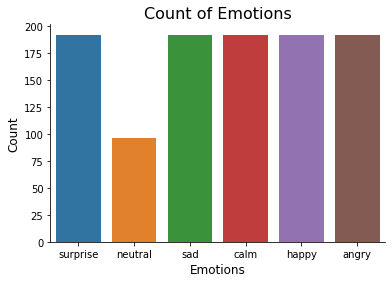

In [50]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Plotting waveplots and spectograms for audio signals.

In [51]:
def create_waveplot(data, sr):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio', size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio', size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

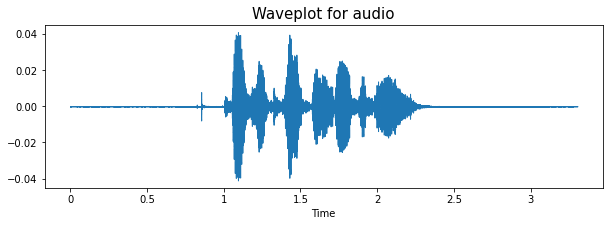

In [52]:
path = "/kaggle/input/ravdess-emotional-speech-audio/Actor_01/03-01-01-01-01-01-01.wav"
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
Audio(path)

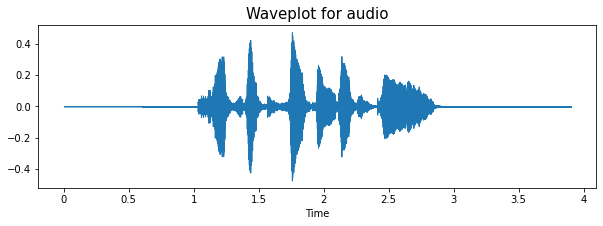

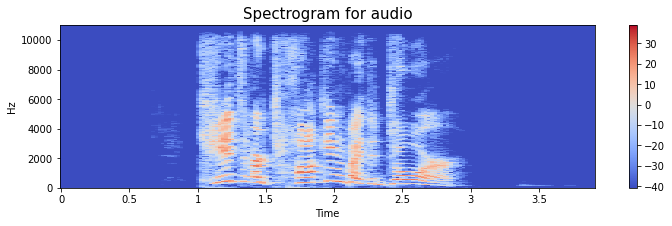

In [53]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

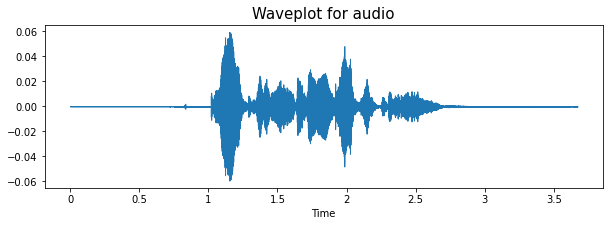

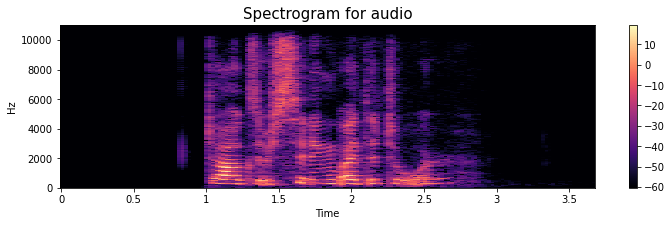

In [54]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

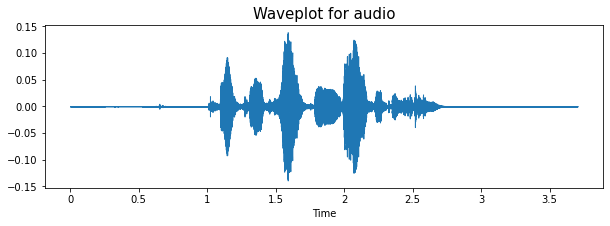

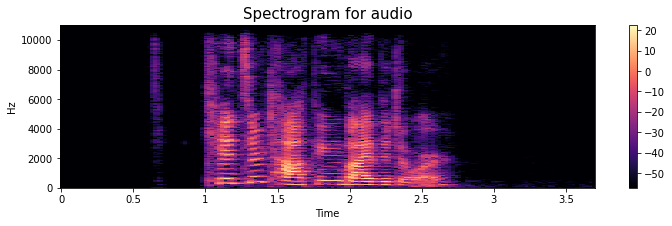

In [55]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate)
create_spectrogram(data, sampling_rate)
Audio(path)

In [56]:
def extract_features(data, sample_rate):
    # MFCC - Extracting 40 MFCC coefficients
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    
    # Chroma feature
    chroma = librosa.feature.chroma_stft(y=data, sr=sample_rate)
    
    # Spectral contrast feature
    spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=sample_rate)
    
    # Concatenating all the features
    result = np.concatenate((mfcc, chroma, spectral_contrast), axis=0)
    return result

# Update the `get_features` function to pass `sample_rate` to `extract_features`
def get_features(path):
    # Load audio data with duration and offset
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # List of augmentation functions
    fns = [noise, pitch, "None"]

    # Apply augmentations and extract features
    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res1 = extract_features(fn2_data, sample_rate)
    result = [np.array(res1)]

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res2 = extract_features(fn2_data, sample_rate)
    result.append(res2)

    fn1_data = transform_audio(data, fns)
    fn2_data = transform_audio(fn1_data, fns)
    res3 = extract_features(fn2_data, sample_rate)
    result.append(res3)

    return result


In [31]:
def extract_features(data, sample_rate):
    # MFCC - Extracting 40 MFCC coefficients
    mfcc = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)
    
    # Chroma feature
    chroma = librosa.feature.chroma_stft(y=data, sr=sample_rate)
    
    # Spectral contrast feature
    spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=sample_rate)

    # Print shapes of the individual feature sets
    print(f"MFCC shape: {mfcc.shape}")
    print(f"Chroma shape: {chroma.shape}")
    print(f"Spectral Contrast shape: {spectral_contrast.shape}")
    
    # Concatenate features
    result = np.concatenate((mfcc, chroma, spectral_contrast), axis=0)
    return result


In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path.to_list(), data_path.Emotions.to_list()):
    feature = get_features(path)
    for ele in feature:
        # Update this shape check based on the new feature shape
        if ele.shape == (59, 108):  # Adjust to the correct shape based on the print output
            X.append(ele)
            Y.append(emotion)
        else:
            print(f"Skipping feature with incorrect shape: {ele.shape}")


MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12, 108)
Spectral Contrast shape: (7, 108)
MFCC shape: (40, 108)
Chroma shape: (12,

In [57]:
# Verify data
print(f"Number of samples: {len(X)}")
print(f"Number of labels: {len(Y)}")


Number of samples: 4275
Number of labels: 4275


In [58]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding for labels
encoder = OneHotEncoder()
Y_encoded = encoder.fit_transform(np.array(Y).reshape(-1, 1)).toarray()

# Check if encoding is correct
print(f"Shape of encoded labels: {Y_encoded.shape}")


Shape of encoded labels: (34200, 2)


## Data Augmentation

- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- Using Random transformations and augmenting data before training.

## Feature Extraction
With the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it. Extracting MFCC for the current experiment.

> MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.

In [44]:
dfm = pd.DataFrame()
xx = pd.Series(X)
for i in range(20):
    dfm[i] = [k[i] for k in xx]

In [45]:
Features = dfm.copy()
Features['labels'] = Y
#Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,"[-780.6990356445312, -775.211181640625, -742.3...","[0.0, -3.722505569458008, -18.492427825927734,...","[0.0, 2.3184618949890137, 2.4432199001312256, ...","[0.0, 0.06972754001617432, 10.677165985107422,...","[0.0, 1.1572920083999634, 4.076608657836914, 5...","[0.0, 1.1284782886505127, -3.1562037467956543,...","[0.0, -3.1943297386169434, -12.803915023803711...","[0.0, 2.705510139465332, 3.9245877265930176, 1...","[0.0, -0.0588599294424057, 1.6160660982131958,...","[0.0, -0.6296786665916443, -0.9115900993347168...",...,"[0.0, 1.6613699197769165, 9.03053092956543, 9....","[0.0, 1.049992322921753, 9.87402057647705, 15....","[0.0, 0.8225840330123901, -0.5474645495414734,...","[0.0, -1.481282353401184, -6.0747575759887695,...","[0.0, 5.488043308258057, 16.446809768676758, 1...","[0.0, -2.414310932159424, -4.259477138519287, ...","[0.0, 1.5316033363342285, -2.9748075008392334,...","[0.0, 0.24373817443847656, -2.7291736602783203...","[0.0, 0.3147801160812378, 4.681241989135742, 3...",surprise
1,"[-489.5006962539414, -450.17788701324184, -446...","[-4.928291107776473, -6.271110382668608, -7.49...","[6.416733844968791, -0.4798101274284137, -3.27...","[-0.8402651862721944, -3.651474929942579, -4.8...","[-0.5277222851594049, -5.623352210571688, -3.1...","[7.953153465753899, 5.572980530944577, -0.2291...","[7.31968943979561, 7.094137385273584, 1.895354...","[0.9642968048110943, 2.7990518495563643, -0.54...","[-6.363838012192344, -3.0600475453828535, -4.0...","[0.07691564731361089, 4.258001374402673, -1.40...",...,"[-3.811630457506319, -2.8242936449887974, -3.1...","[-0.9509722423214553, -2.842628128964359, -5.3...","[5.568662639869284, 0.3092983518360252, -2.914...","[-0.019018228188262487, -1.1307422238634746, 0...","[-1.7854063115118968, -0.47269263591916455, 0....","[4.377515406241817, 1.3848825297071279, 0.3450...","[5.512540876379479, 5.614867547711129, 1.58125...","[-0.2001411042374317, -0.5797836025573471, -0....","[-1.8848862517146636, -4.0885605536103125, -3....",surprise
2,"[-393.01007353980145, -351.4653605822675, -344...","[-10.21717544876013, -5.696905553897322, -1.98...","[4.789331732094187, -0.17314149839507487, 0.18...","[3.649607491538404, -0.9583022268822794, -0.79...","[4.337767450074403, 0.009298307677728879, -3.2...","[7.431786978139723, 1.8909449479917169, -2.577...","[4.641929763381831, 0.03504135445090775, 1.011...","[-6.768658887561537, -1.6510414385274155, 1.33...","[-11.818667015186914, -3.3018591696236905, 3.3...","[-4.127927592078736, -1.1264969184675264, -0.2...",...,"[-6.870114715043995, -3.5571554477151976, -0.9...","[-6.730796772318063, -0.8884349628959778, 3.88...","[-2.5234849562911963, 3.575886087720951, 5.083...","[2.482985023778996, 6.166073497307023, 1.81332...","[-5.357042873840578, -1.873589123608509, -4.02...","[-4.354318755970757, -6.005218598455899, 0.329...","[0.4791673666183317, -3.7242592596009434, 0.82...","[3.7033839248417024, -4.705035970764584, -4.93...","[5.246899376375798, -0.27960009347960313, -3.5...",surprise
3,"[-489.5046267959649, -457.4896694456234, -448....","[-9.322950409945133, -8.245852263746626, -0.62...","[2.778312113365736, 3.606805678922982, 1.26177...","[-6.389446046129733, -4.332960501576848, -2.48...","[-2.2378030108941407, -3.5385115105327625, -1....","[-1.0922153348417447, 2.326670381722586, 0.061...","[-3.29194267963636, 1.8345473291147658, 1.6211...","[1.7652110937441152, 2.732520854182337, 0.3580...","[2.4267846795335513, 4.215530174411162, 1.1968...","[-2.51046940939182, 1.7688258322854002, 3.2103...",...,"[-9.371749625802241, -4.757831724588828, 1.918...","[-6.397240734080379, 0.6320998773507409, 3.372...","[-5.99973808953745, 0.1262818193925739, -3.190...","[-0.30974152914657405, 0.9213524174103864, -4....","[5.031029505286177, 3.3278238696288076, 1.0331...","[-4.0983237720753785, -2.542504713686261, -2.0...","[-2.1182059434112057, -3.4131364595798392, -0....","[2.129447829247908, -0.8987566542816353, 

In [46]:
X = np.array(X)
Y = np.array(Y)
X.shape, Y.shape

((2655, 59, 108), (2655,))

## Data Preparation

In [47]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [48]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2124, 59, 108), (2124, 5), (531, 59, 108), (531, 5))

In [49]:
# making data compatible to model.
x_train = np.expand_dims(x_train, axis=3)
x_train = np.swapaxes(x_train, 1, 2)
x_train = np.expand_dims(x_train, axis=3)

x_test = np.expand_dims(x_test, axis=3)
x_test = np.swapaxes(x_test, 1, 2)
x_test = np.expand_dims(x_test, axis=3)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2124, 108, 59, 1, 1), (2124, 5), (531, 108, 59, 1, 1), (531, 5))

## Modelling

In [51]:
input_shape = x_train.shape[1:]
input_shape #(108, 162, 1, 1)

(108, 59, 1, 1)

In [52]:
# Initialize the model
model = Sequential()

# TimeDistributed wrapper with Conv1D layers for temporal data
model.add(TimeDistributed(Conv1D(32, 3, padding='same', activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.2)))

# Second Conv1D layer
model.add(TimeDistributed(Conv1D(64, 3, padding='same', activation='relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(Dropout(0.3)))

# Flattening the output from TimeDistributed Conv layers
model.add(TimeDistributed(Flatten()))

# LSTM layers to capture temporal dependencies
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))

# Fully connected Dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.2))

# Output layer for 8-class classification
model.add(Dense(units=8, activation='softmax'))

# Display the model architecture summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 108, 59, 1, 32)    128       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 108, 59, 1, 32)    128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 108, 59, 1, 32)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 108, 59, 1, 64)    6208      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 108, 59, 1, 64)    256       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 108, 59, 1, 64)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 108, 3776)        

In [53]:
from keras.optimizers import adam_v2
optimizer = adam_v2.Adam()
model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=4, min_lr=0.0000001)

epochs = 100
history = model.fit(x_train, y_train, batch_size=128, epochs=epochs, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/100
17/17 [==============================] - 37s 1s/step - loss: 1.5960 - accuracy: 0.2495 - val_loss: 1.5851 - val_accuracy: 0.2693
Epoch 2/100
17/17 [==============================] - 16s 934ms/step - loss: 1.5228 - accuracy: 0.3380 - val_loss: 1.5450 - val_accuracy: 0.3013
Epoch 3/100
17/17 [==============================] - 16s 938ms/step - loss: 1.4171 - accuracy: 0.4007 - val_loss: 1.7690 - val_accuracy: 0.2957
Epoch 4/100
17/17 [==============================] - 16s 938ms/step - loss: 1.3347 - accuracy: 0.4449 - val_loss: 1.8498 - val_accuracy: 0.2768
Epoch 5/100
17/17 [==============================] - 16s 943ms/step - loss: 1.2687 - accuracy: 0.4689 - val_loss: 1.7374 - val_accuracy: 0.3390
Epoch 6/100
17/17 [==============================] - 16s 947ms/step - loss: 1.2107 - accuracy: 0.4939 - val_loss: 1.7129 - val_accuracy: 0.3540

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 7/100
17/17 [==============================] - 16s 9

17/17 [==============================] - 0s 16ms/step - loss: 0.5822 - accuracy: 0.8023
Accuracy of our model on test data :  80.22598624229431 %


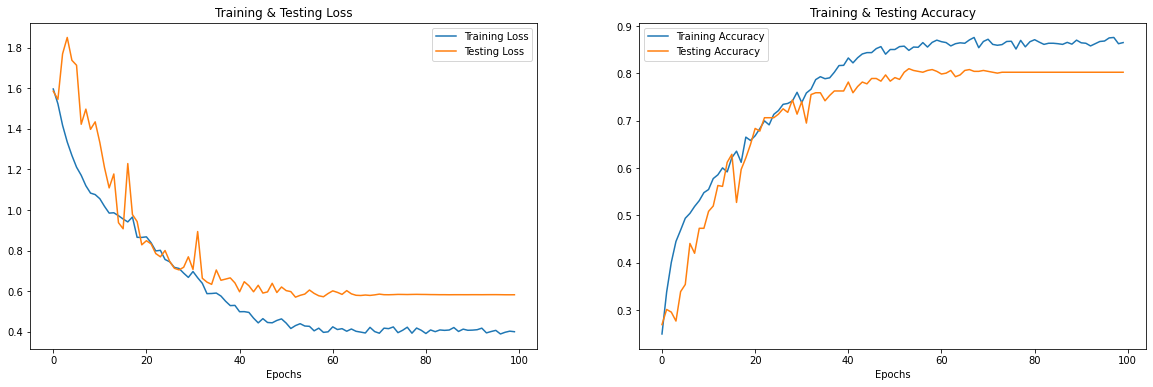

In [54]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(100)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [55]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [56]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(30)

,Predicted Labels,Actual Labels
0,angry,angry
1,surprise,surprise
2,neutral,neutral
3,neutral,neutral
4,neutral,neutral
5,angry,angry
6,surprise,surprise
7,surprise,happy
8,sad,sad
9,neutral,sad


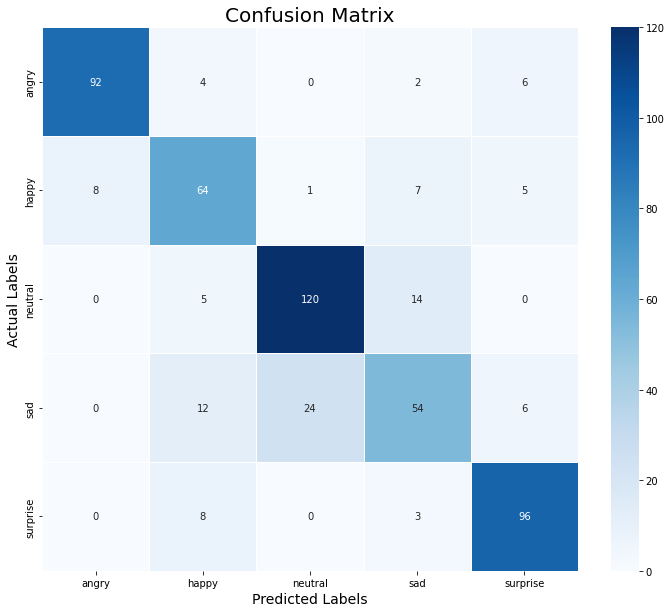

In [57]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.92      0.88      0.90       104
       happy       0.69      0.75      0.72        85
     neutral       0.83      0.86      0.85       139
         sad       0.68      0.56      0.61        96
    surprise       0.85      0.90      0.87       107

    accuracy                           0.80       531
   macro avg       0.79      0.79      0.79       531
weighted avg       0.80      0.80      0.80       531



In [37]:
model.save('five_emotion-audio-5-83.keras')